In [1]:

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

from PIL import Image
from keras import layers, models, optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.layers import Activation
from keras.callbacks import EarlyStopping, ModelCheckpoint

Using TensorFlow backend.


In [2]:
def display_grid(data, path, w =10, h =10, columns = 4, rows = 5):
    fig=plt.figure(figsize=(12, 8))
    for i in range(1, columns*rows +1):
        file = data[i]
        file = os.path.join(path, file)
        img = Image.open(file)
        fig.add_subplot(rows, columns, i)
        imshow(img)
    plt.show()
    
def plot_results(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.figure(figsize = (24, 6))
    plt.subplot(1,2,1)
    plt.plot(epochs, acc, 'b', label = 'Training Accuracy')
    plt.plot(epochs, val_acc, 'r', label = 'Validation Accuracy')
    plt.grid(True)
    plt.legend()
    plt.xlabel('Epoch')
    


    plt.subplot(1,2,2)
    plt.plot(epochs, loss, 'b', label = 'Training Loss')
    plt.plot(epochs, val_loss, 'r', label = 'Validation Loss')
    plt.grid(True)
    plt.legend()
    plt.xlabel('Epoch')
    plt.show()
 
def get_best_epcoh(history):
    valid_acc = history.history['val_acc']
    best_epoch = valid_acc.index(max(valid_acc)) + 1
    best_acc =  max(valid_acc)
    print('Best Validation Accuracy Score {:0.5f}, is for epoch {}'.format( best_acc, best_epoch))
    return best_epoch

## Class Swift

In [3]:
base_dir = '/kaggle/input/cars-wagonr-swift/data/'
train_swift = os.listdir(os.path.join(base_dir, 'train/swift') )
val_swift  = os.listdir(os.path.join(base_dir, 'validation/swift') )
test_swift  =  os.listdir(os.path.join(base_dir, 'test/swift') )
print('Instances for Class Swift: Train {}, Validation {} Test {}'.format(len(train_swift), len(val_swift), len(test_swift)))

Instances for Class Swift: Train 1200, Validation 400 Test 400


In [4]:
#Sanity checks: no overlaping bteween train test and validation sets
val_train = [x for x in val_swift if x in train_swift]
test_train = [x for x in test_swift if x in train_swift]
val_test =  [x for x in test_swift if x in val_swift]
len(val_train), len(test_train), len(val_test)

(0, 0, 0)

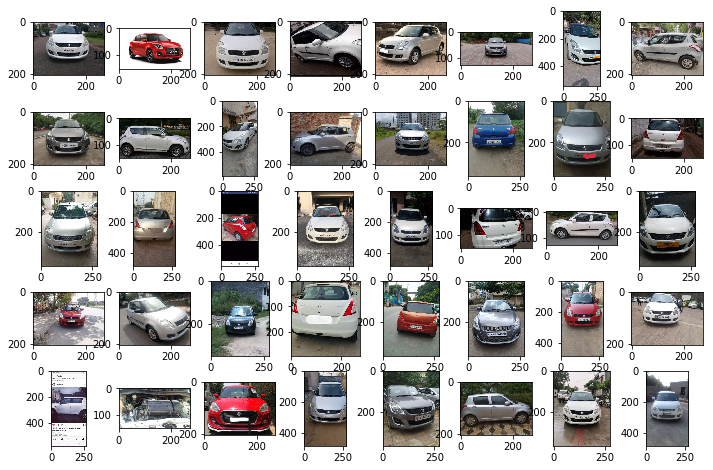

In [5]:
display_grid(data = train_swift, path = os.path.join(base_dir, 'train/swift'), w =10, h =10, columns = 8, rows = 5)

## Class Wagonr

In [6]:
train_wr = os.listdir(os.path.join(base_dir, 'train/wagonr') )
val_wr  = os.listdir(os.path.join(base_dir, 'validation/wagonr') )
test_wr  =  os.listdir(os.path.join(base_dir, 'test/wagonr') )
print('Instances for Class Wagonr: Train {}, Validation {} Test {}'.format(len(train_swift), len(val_swift), len(test_swift)))

Instances for Class Wagonr: Train 1200, Validation 400 Test 400


In [7]:
#Sanity checks: no overlaping bteween train test and validation sets
val_train = [x for x in val_wr if x in train_wr]
test_train = [x for x in test_wr if x in train_wr]
val_test =  [x for x in test_wr if x in val_wr]
len(val_train), len(test_train), len(val_test)

(0, 0, 0)

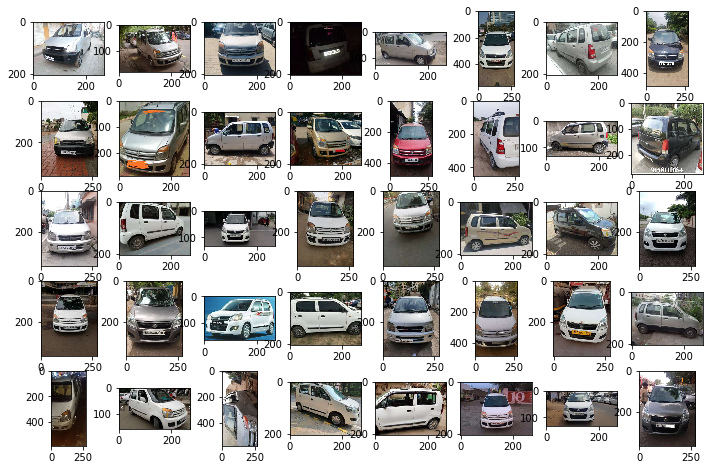

In [8]:
display_grid(data = train_wr, path = os.path.join(base_dir, 'train/wagonr'), w =10, h =10, columns = 8, rows = 5)

## Build CNN Model 

In [9]:
def build_cnn(display_summary =False):
    model = models.Sequential()
    model.add( layers.Conv2D(32, (3,3),  activation= 'relu', input_shape = (150, 150, 3)) )
    model.add(layers.MaxPooling2D((2,2)))

    model.add( layers.Conv2D(64, (3,3),  activation= 'relu') )
    model.add(layers.MaxPooling2D((2,2)))

    model.add( layers.Conv2D(128, (3,3),  activation= 'relu') )
    model.add(layers.MaxPooling2D((2,2)))

    model.add( layers.Conv2D(128, (3,3),  activation= 'relu') )
    model.add(layers.MaxPooling2D((2,2)))

    model.add(layers.Flatten())
    model.add(layers.Dropout(0.5))
        
    model.add(layers.Dense(512, activation= 'relu'))
    model.add(layers.Dense(1, activation= 'sigmoid'))

    model.compile(loss = 'binary_crossentropy',
                  optimizer = optimizers.RMSprop(lr = 1e-4),
                  metrics = ['acc']
                  )
    if display_summary:
       model.summary()
    return model

## Data Preprocessing

### Data Augumenation data example

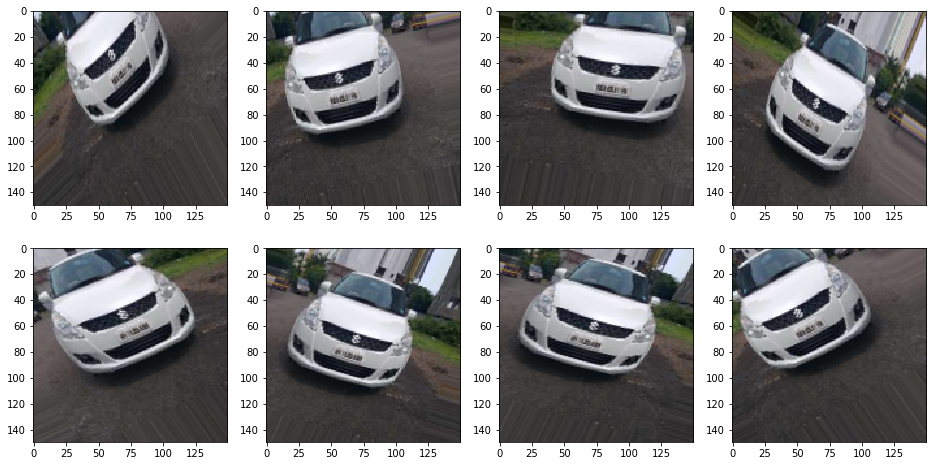

In [10]:
datagen = ImageDataGenerator( rotation_range= 40,
                              width_shift_range = 0.2,
                             height_shift_range = 0.2,
                             shear_range = 0.2,
                             zoom_range = 0.2,
                             horizontal_flip = True,
#                              fill_mode = 'nearest'                              
                            )

path = os.path.join(base_dir, 'train/swift')
file = train_swift[1]
image_path = os.path.join(path, file )

img = image.load_img(image_path, target_size = (150,150))
x= image.img_to_array(img)
x = x.reshape((1,) + x.shape)
i =0 
fig=plt.figure(figsize=(16, 8))
for batch in datagen.flow(x, batch_size = 1):
    i +=  1
    fig.add_subplot(2, 4, i)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
  
    if i % 8 == 0:
        break
    

## Data Preprocessing with Augumentation

In [11]:

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation' )


train_datagen = ImageDataGenerator(
                                  rescale = 1./255,
                                  rotation_range= 40,
                                  width_shift_range = 0.2,
                                  height_shift_range = 0.2,
                                  shear_range = 0.2,
                                  zoom_range = 0.2  ,
                                  horizontal_flip = True,
                                   )
test_datagen = ImageDataGenerator(rescale= 1./255)

train_generator = train_datagen.flow_from_directory(
                                                   train_dir,              
                                                   target_size = (150,150), #Resize images to 150 X 150
                                                   batch_size  = 20,
                                                   class_mode = 'binary'
                                                   )
validation_generator = test_datagen.flow_from_directory(
                                                   validation_dir,              
                                                   target_size = (150,150), #Resize images to 150 X 150
                                                   batch_size  = 20,
                                                   class_mode = 'binary'
                                                   )

for data_batch, labels_batch, in train_generator:
    print('Data Batch shape:', data_batch.shape)
    print('Labels Batch shape:', labels_batch.shape)
    break

Found 2400 images belonging to 2 classes.
Found 800 images belonging to 2 classes.
Data Batch shape: (20, 150, 150, 3)
Labels Batch shape: (20,)


### Fit Model

In [12]:
model = build_cnn(display_summary = True)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 15, 15, 128)       147584    
__________

In [13]:
%%time
callback_list = [#save best model                    
                 ModelCheckpoint(filepath= 'model.h5', monitor= 'val_acc', save_best_only= True),

                 ]

history = model.fit_generator(
                            train_generator,
                            steps_per_epoch = 120,  # = num_train_images/batch size(2400/20)
                            epochs = 200,
                            validation_data = validation_generator,
                            callbacks = callback_list,
                            validation_steps = 40  # = num_valid_images/batch_size
                             )


Epoch 1/200
120/120 [==============================] - 30s 249ms/step - loss: 0.6962 - acc: 0.5046 - val_loss: 0.6886 - val_acc: 0.5050
Epoch 2/200
120/120 [==============================] - 19s 155ms/step - loss: 0.6890 - acc: 0.5288 - val_loss: 0.7232 - val_acc: 0.5000
Epoch 3/200
120/120 [==============================] - 19s 157ms/step - loss: 0.6840 - acc: 0.5388 - val_loss: 0.6779 - val_acc: 0.5988
Epoch 4/200
120/120 [==============================] - 19s 156ms/step - loss: 0.6777 - acc: 0.5663 - val_loss: 0.6685 - val_acc: 0.6725
Epoch 5/200
120/120 [==============================] - 19s 156ms/step - loss: 0.6709 - acc: 0.5729 - val_loss: 0.6618 - val_acc: 0.6113
Epoch 6/200
120/120 [==============================] - 19s 155ms/step - loss: 0.6589 - acc: 0.6000 - val_loss: 0.6447 - val_acc: 0.6638
Epoch 7/200
120/120 [==============================] - 19s 156ms/step - loss: 0.6445 - acc: 0.6321 - val_loss: 0.6178 - val_acc: 0.7075
Epoch 8/200
120/120 [===========================

### Train Vs Validation Accuracy/Loss

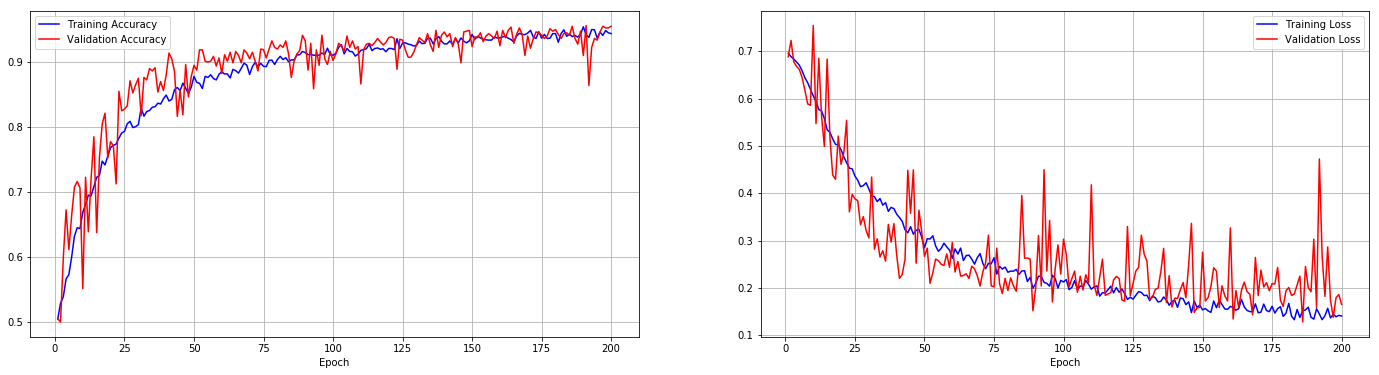

Best Validation Accuracy Score 0.95625, is for epoch 191


In [14]:
plot_results(history)
best_epoch =get_best_epcoh(history)